## **Initial Setup and Data Loading**

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast

# Load the dataset
df = pd.read_csv('founders_dataset.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (1209, 25)


,roles,preferred_role,industry,secondary_industries,years_of_experience,is_technical,education_level,tech_stack,strengths,weaknesses,...,gender,collaboration_openness_score,communication_intensity_score,responsiveness_score,risk_tolerance,leadership,autonomy,vision,communication,execution_speed
0,"[""COO""]",COO,Other,[],4,False,bachelor,"[""Swift"", ""Node.js""]","[""User empathy"", ""Communication skills"", ""Anal...","[""Risk-averse"", ""Impatient with slow processes""]",...,M,0.036290,0.024107,0.143475,2,2,3,3,3,4
1,"[""CEO""]",CEO,Gaming / Entertainment,[],7,True,self-taught,"[""Unity"", ""C#"", ""JavaScript"", ""Webflow""]","[""User empathy"", ""Team-building"", ""Creativity ...","[""Poor work-life balance"", ""Limited business e...",...,M,0.031654,0.010418,0.177019,4,2,3,4,5,5
2,"[""CEO""]",CEO,Consumer / Social,[],3,False,bachelor,"[""React"", ""Node.js"", ""Firebase""]","[""Creativity and vision"", ""High ownership"", ""P...","[""Overly detail-oriented"", ""Weak in sales""]",...,M,0.022029,0.003984,0.092243,4,5,4,3,5,3
3,"[""COO""]",COO,Fintech,[],12,False,master,"[""Figma"", ""Swift"", ""Notion"", ""AWS""]","[""High ownership"", ""Resilience"", ""Fast executi...","[""Overly optimistic"", ""Easily distracted by ne...",...,M,0.277378,0.036848,0.127754,4,2,2,4,4,5
4,"[""CTO""]",CTO,Other,[],2,True,bachelor,"[""AWS"", ""Django"", ""Swift"", ""Docker""]","[""Resilience"", ""Scrappiness"", ""Strong leadersh...","[""Overly detail-oriented"", ""Poor work-life bal...",...,M,0.195837,0.125118,0.038137,4,3,3,2,4,3


## **Data Preprocessing**

Before clustering, we need to convert all features into numerical format. This involves:

1. **Multi-label encoding**: Convert list-like columns (roles, tech_stack, etc.) to binary features
2. **Text embeddings**: Convert text descriptions into numerical vectors using sentence transformers
3. **Categorical encoding**: One-hot encode single-value categorical features
4. **Numeric scaling**: Standardize numerical features

### **Column Classification**

Categorize columns by their data type to apply appropriate preprocessing:

- **Multi-label columns**: Contain lists of values (e.g., roles, tech_stack, strengths)
- **Text columns**: Contain descriptions that need embedding (idea_title, idea_description, problem_space)
- **Categorical columns**: Single categorical values (preferred_role, industry, education_level)
- **Numeric columns**: Numerical features to be standardized

In [6]:
# Define column types
multi_label_cols = [
    'roles',
    'secondary_industries', 
    'tech_stack',
    'strengths',
    'weaknesses'
]

text_cols = [
    'idea_title',
    'idea_description', 
    'problem_space'
]

categorical_cols = [
    'preferred_role',
    'industry',
    'education_level',
    'gender',
    'is_technical'
]

numeric_cols = [
    'years_of_experience',
    'age',
    'collaboration_openness_score',
    'communication_intensity_score',
    'responsiveness_score',
    'risk_tolerance',
    'leadership',
    'autonomy',
    'vision',
    'communication',
    'execution_speed'
]


### **Parse Multi-Label Columns**

Convert string representations of lists into actual Python lists for processing.

In [7]:
# Convert list-like strings to actual lists
for col in multi_label_cols:
    df[col] = df[col].fillna('[]').apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Display sample of parsed data
print("Sample of parsed multi-label columns:")
df[multi_label_cols].head(3)

Sample of parsed multi-label columns:


,roles,secondary_industries,tech_stack,strengths,weaknesses
0,[COO],[],"[Swift, Node.js]","[User empathy, Communication skills, Analytica...","[Risk-averse, Impatient with slow processes]"
1,[CEO],[],"[Unity, C#, JavaScript, Webflow]","[User empathy, Team-building, Creativity and v...","[Poor work-life balance, Limited business expe..."
2,[CEO],[],"[React, Node.js, Firebase]","[Creativity and vision, High ownership, Produc...","[Overly detail-oriented, Weak in sales]"


### **Generate Text Embeddings**

Use SentenceTransformer to convert text descriptions into dense numerical vectors that capture semantic meaning.

In [8]:
from sentence_transformers import SentenceTransformer

# Initialize the text embedding model
text_model = SentenceTransformer("all-MiniLM-L6-v2")

def embed_text_column(col):
    """Embed a text column using SentenceTransformer"""
    return np.vstack(df[col].apply(lambda x: text_model.encode(str(x))))

# Generate embeddings for all text columns
text_embeddings = np.hstack([embed_text_column(col) for col in text_cols])

print(f"Text embeddings shape: {text_embeddings.shape}")
print(f"Each text column produces 384-dimensional embeddings")

Text embeddings shape: (1209, 1152)
Each text column produces 384-dimensional embeddings


### **Multi-Label Binarization**

Convert multi-label columns into binary feature vectors using MultiLabelBinarizer.

In [9]:
from sklearn.preprocessing import MultiLabelBinarizer

# Process each multi-label column
mlb_features = {}
for col in multi_label_cols:
    mlb = MultiLabelBinarizer()
    mlb_features[col] = mlb.fit_transform(df[col])
    print(f"{col}: {mlb_features[col].shape[1]} unique values")

# Show total binary features created
total_mlb_features = sum(feat.shape[1] for feat in mlb_features.values())
print(f"\nTotal multi-label binary features: {total_mlb_features}")

roles: 4 unique values
secondary_industries: 1 unique values
tech_stack: 75 unique values
strengths: 14 unique values
weaknesses: 14 unique values

Total multi-label binary features: 108


### **Encode Categorical and Numeric Features**

Use scikit-learn's ColumnTransformer to process categorical and numeric features together.

In [10]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Create preprocessing pipeline
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", StandardScaler(), numeric_cols),
    ]
)

# Fit and transform the structured features
X_structured = preprocess.fit_transform(df)

print(f"Structured features shape: {X_structured.shape}")

Structured features shape: (1209, 37)


### **Combine All Features**

Merge all feature types into a single feature matrix for clustering.

In [11]:
# Combine all features: structured + multi-label + text embeddings
X = np.hstack([
    X_structured,
    *[mlb_features[col] for col in multi_label_cols],
    text_embeddings
])

print(f"Final feature matrix shape: {X.shape}")
print(f"Total features per founder: {X.shape[1]}")

Final feature matrix shape: (1209, 1297)
Total features per founder: 1297


## **Dimensionality Reduction with PCA**

Since we have many features, we'll use Principal Component Analysis (PCA) to reduce dimensionality while retaining most of the variance. This helps:
- Speed up clustering algorithms
- Reduce noise in the data
- Avoid curse of dimensionality

Variance explained by 70 components: 0.924


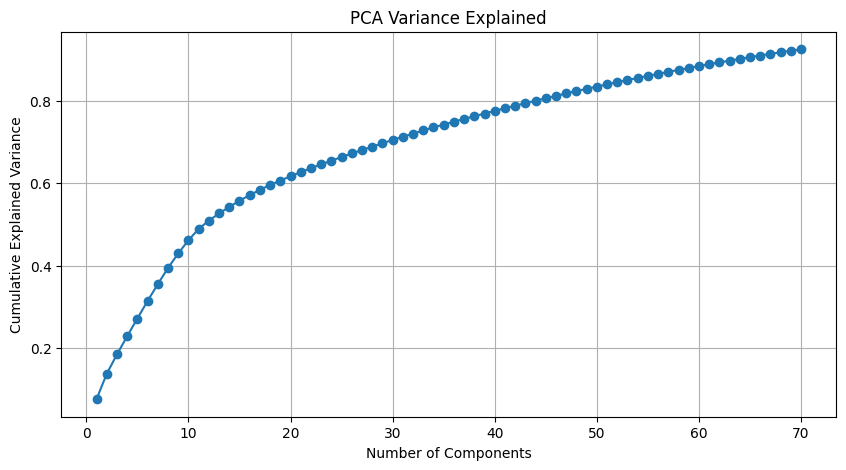


Reduced feature matrix shape: (1209, 70)
Optimal number of PCA components for 90% variance: 64


In [12]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensions
n_components = 70
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

# Show variance explained
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Variance explained by {n_components} components: {cumulative_variance[-1]:.3f}")

# Plot variance explained
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_components + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Variance Explained')
plt.grid(True)
plt.show()

print(f"\nReduced feature matrix shape: {X_pca.shape}")

# choose optimal number of PCA components based on variance explained plot >= 0.9
n_components = cumulative_variance.searchsorted(0.9) + 1
print(f"Optimal number of PCA components for 90% variance: {n_components}")

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

## **Determine Optimal Number of Clusters**

Use the elbow method to find the optimal number of clusters by plotting the inertia (sum of squared distances to nearest cluster center) for different values of k.

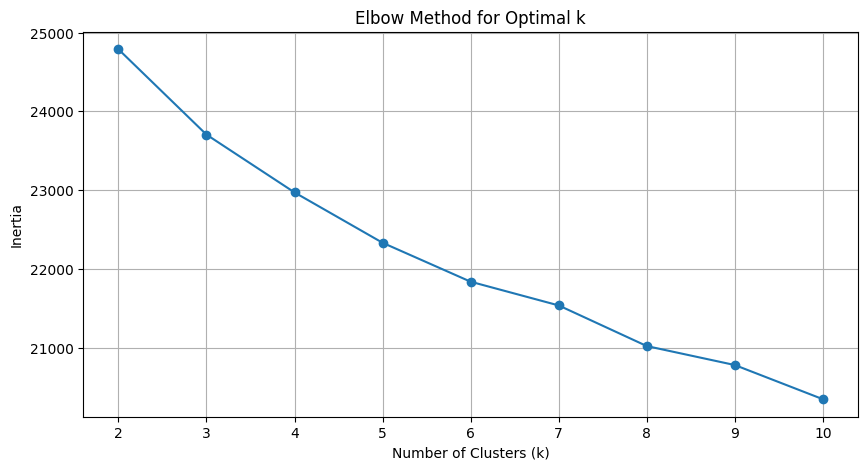

Inertia values for different k:
k=2: 24788.27
k=3: 23705.64
k=4: 22972.27
k=5: 22333.65
k=6: 21839.86
k=7: 21538.97
k=8: 21023.66
k=9: 20782.94
k=10: 20349.64


In [13]:
from sklearn.cluster import KMeans

# Test different numbers of clusters
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 5))
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

print("Inertia values for different k:")
for k, inertia in zip(k_range, inertias):
    print(f"k={k}: {inertia:.2f}")

## **Perform KMeans Clustering**

Apply KMeans clustering with the chosen number of clusters and assign cluster labels to each founder.

In [14]:
n_clusters = 4

# Perform clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
clusters = kmeans.fit_predict(X_pca)

# Add cluster labels to dataframe
df['cluster'] = clusters

print(f"Number of founders in each cluster:")
print(df['cluster'].value_counts().sort_index())

Number of founders in each cluster:
cluster
0    327
1    204
2    668
3     10
Name: count, dtype: int64


## **Visualize Clusters**

Use dimensionality reduction (PCA or t-SNE) to visualize the clusters in 2D space.

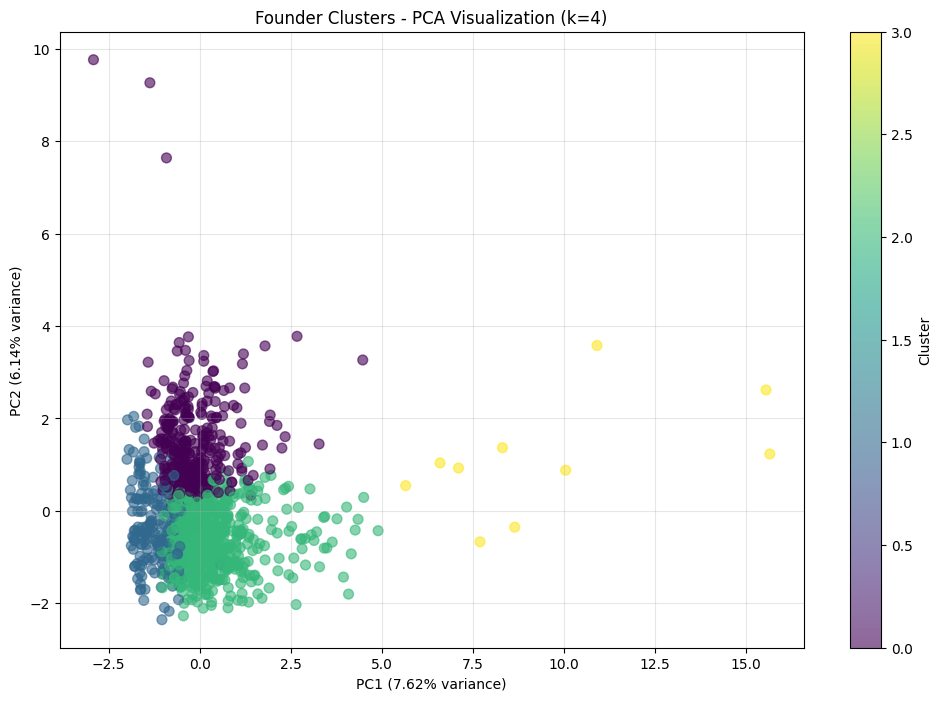

In [22]:
# Simple 2D PCA visualization
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=clusters, cmap='viridis', alpha=0.6, s=50)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
plt.title(f'Founder Clusters - PCA Visualization (k={n_clusters})')
plt.grid(True, alpha=0.3)
plt.show()

## **Analyze Cluster Characteristics**

Examine the characteristics of each cluster to understand what makes each group unique.

In [23]:
# Analyze numeric features by cluster
numeric_analysis = df.groupby('cluster')[numeric_cols].mean()
print("Average numeric features by cluster:")
print(numeric_analysis.round(2))

Average numeric features by cluster:
         years_of_experience    age  collaboration_openness_score  \
cluster                                                             
0                       7.62  29.51                          0.04   
1                       4.18  23.19                          0.01   
2                       3.47  22.23                          0.06   
3                       6.10  26.10                          0.67   

         communication_intensity_score  responsiveness_score  risk_tolerance  \
cluster                                                                        
0                                 0.01                  0.25            3.56   
1                                 0.00                  0.77            3.53   
2                                 0.02                  0.21            3.32   
3                                 0.44                  0.14            3.40   

         leadership  autonomy  vision  communication  execution_spe

In [24]:
# Analyze categorical features by cluster
print("CLUSTER PROFILES - CATEGORICAL FEATURES")

for cluster_id in sorted(df['cluster'].unique()):
    cluster_data = df[df['cluster'] == cluster_id]
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id} (n={len(cluster_data)} founders)")
    print(f"{'='*80}")
    
    # Most common categorical values
    print("\nPreferred Roles:")
    print(cluster_data['preferred_role'].value_counts().head())
    
    print("\nIndustries:")
    print(cluster_data['industry'].value_counts().head())
    
    print("\nEducation Levels:")
    print(cluster_data['education_level'].value_counts().head())
    
    print("\nGender Distribution:")
    print(cluster_data['gender'].value_counts())

CLUSTER PROFILES - CATEGORICAL FEATURES

CLUSTER 0 (n=327 founders)

Preferred Roles:
preferred_role
CEO    117
CTO    105
CPO     57
COO     48
Name: count, dtype: int64

Industries:
industry
Biotech                   38
Gaming / Entertainment    33
Climate / Greentech       29
Marketplaces              29
E-commerce                28
Name: count, dtype: int64

Education Levels:
education_level
master         110
bachelor        68
bootcamp        66
self-taught     57
phd             26
Name: count, dtype: int64

Gender Distribution:
gender
M    290
F     37
Name: count, dtype: int64

CLUSTER 1 (n=204 founders)

Preferred Roles:
preferred_role
CTO    80
CEO    70
COO    29
CPO    25
Name: count, dtype: int64

Industries:
industry
AI / Deeptech        21
Web3 / Crypto        19
Fintech              18
Consumer / Social    17
Edtech               17
Name: count, dtype: int64

Education Levels:
education_level
bachelor       71
self-taught    51
master         41
bootcamp       33
phd  

In [25]:
# Analyze multi-label features (most common values in each cluster)
print("CLUSTER PROFILES - MULTI-LABEL FEATURES")

for cluster_id in sorted(df['cluster'].unique()):
    cluster_data = df[df['cluster'] == cluster_id]
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*80}")
    
    # Flatten lists and count occurrences
    for col in ['roles', 'tech_stack', 'strengths', 'weaknesses']:
        all_values = [item for sublist in cluster_data[col] for item in sublist]
        if all_values:
            value_counts = pd.Series(all_values).value_counts().head(5)
            print(f"\nTop {col}:")
            print(value_counts)

CLUSTER PROFILES - MULTI-LABEL FEATURES

CLUSTER 0

Top roles:
CTO    122
CEO    119
CPO     83
COO     56
Name: count, dtype: int64

Top tech_stack:
Python    80
AWS       66
React     63
Notion    63
Figma     61
Name: count, dtype: int64

Top strengths:
Creativity and vision         82
Strong leadership             82
Scrappiness                   80
User empathy                  78
Analytical problem-solving    77
Name: count, dtype: int64

Top weaknesses:
Weak in hiring                    58
Easily distracted by new ideas    52
Impatient with slow processes     51
Difficulty delegating             51
Weak in sales                     49
Name: count, dtype: int64

CLUSTER 1

Top roles:
CTO    87
CEO    70
COO    37
CPO    35
Name: count, dtype: int64

Top tech_stack:
Python        60
Node.js       49
Firebase      39
PostgreSQL    38
Django        37
Name: count, dtype: int64

Top strengths:
Creativity and vision    74
User empathy             56
Scrappiness              54
High ow

## **Sample Founders from Each Cluster**

Display sample founders from each cluster to get a concrete understanding of cluster characteristics.

In [26]:
# Display sample founders from each cluster
for cluster_id in sorted(df['cluster'].unique()):
    print(f"\n{'='*80}")
    print(f"SAMPLE FOUNDERS FROM CLUSTER {cluster_id}")
    print(f"{'='*80}\n")
    
    cluster_data = df[df['cluster'] == cluster_id]
    sample = cluster_data.sample(min(3, len(cluster_data)))
    
    for idx, row in sample.iterrows():
        print(f"Founder: {row['founder_id']}")
        print(f"  Role: {row['preferred_role']}, Industry: {row['industry']}")
        print(f"  Experience: {row['years_of_experience']} years, Age: {row['age']}")
        print(f"  Idea: {row['idea_title']}")
        print(f"  Tech Stack: {', '.join(row['tech_stack'][:3]) if row['tech_stack'] else 'None'}")
        print(f"  Strengths: {', '.join(row['strengths'][:2]) if row['strengths'] else 'None'}")
        print()


SAMPLE FOUNDERS FROM CLUSTER 0

Founder: c9f3480c9746f42aec8ca46f8283d210
  Role: CEO, Industry: SaaS
  Experience: 6 years, Age: 41
  Idea: SaaS Innovation Project
  Tech Stack: Webflow, Django, MongoDB
  Strengths: Ability to learn quickly, Communication skills

Founder: c79296907b699ef5c9eb82130c5ee63a
  Role: CTO, Industry: Other
  Experience: 9 years, Age: 29
  Idea: Smart Personal Finance Manager
  Tech Stack: Python, Docker, AWS
  Strengths: High ownership, Fast execution

Founder: cb1301214afde78703c05776cfa8f478
  Role: CEO, Industry: Consumer / Social
  Experience: 6 years, Age: 27
  Idea: Social Engagement Platform for Local Communities
  Tech Stack: Python, Excel, React
  Strengths: Strong leadership, Creativity and vision


SAMPLE FOUNDERS FROM CLUSTER 1

Founder: e42d505b420314e372ac192c0be5b7c5
  Role: CTO, Industry: E-commerce
  Experience: 3 years, Age: 21
  Idea: E-commerce Innovation Project
  Tech Stack: Node.js, Firebase, Webflow
  Strengths: High ownership, Scrap

## **Results**

Save the clustering results to a CSV file for further analysis.

In [ ]:
print(f"Clustering results saved to 'founders_clusters.csv'")
print(f"\nCluster distribution:")
print(df['cluster'].value_counts().sort_index())

Clustering results saved to 'founders_clusters.csv'

Cluster distribution:
cluster
0    327
1    204
2    668
3     10
Name: count, dtype: int64


Calculate silhouette scores to evaluate cluster quality. Higher scores indicate better-defined clusters.

In [29]:
from sklearn.metrics import silhouette_score, silhouette_samples

# Calculate overall silhouette score
silhouette_avg = silhouette_score(X_pca, clusters)
print(f"Average Silhouette Score: {silhouette_avg:.3f}")

# Calculate silhouette score for each cluster
for cluster_id in sorted(df['cluster'].unique()):
    cluster_mask = clusters == cluster_id
    cluster_silhouette = silhouette_samples(X_pca, clusters)[cluster_mask].mean()
    print(f"Cluster {cluster_id} Silhouette Score: {cluster_silhouette:.3f}")

Average Silhouette Score: 0.051
Cluster 0 Silhouette Score: 0.008
Cluster 1 Silhouette Score: 0.057
Cluster 2 Silhouette Score: 0.069
Cluster 3 Silhouette Score: 0.171


Clustering results indicate that the current clustering is very weak. The average silhouette score of 0.051 is extremely low, suggesting that the clusters are barely better than random assignments, with many points likely overlapping or misassigned. Looking at the clusters individually, only Cluster 2 shows any mild structure with a score of 0.176, while the other clusters have scores close to zero, indicating almost no separation between them. Overall, this suggests that the data does not naturally form five distinct clusters, and the chosen number of clusters (k=5) is likely not optimal.